In [1]:
!pip install numpy --upgrade
electro_tests = []
obs_frame = {}
test_frame = {}
import os
import pickle
try: 

    electro_path = str(os.getcwd())+'all_tests.p'

    assert os.path.isfile(electro_path) == True
    with open(electro_path,'rb') as f:
        (obs_frame,test_frame) = pickle.load(f)

except:
    for p in pipe:
        p_tests, p_observations = get_neab.get_neuron_criteria(p)
        obs_frame[p["name"]] = p_observations#, p_tests))
        test_frame[p["name"]] = p_tests#, p_tests))
    electro_path = str(os.getcwd())+'all_tests.p'
    with open(electro_path,'wb') as f:
        pickle.dump((obs_frame,test_frame),f)

Requirement already up-to-date: numpy in /opt/conda/lib/python3.5/site-packages (1.15.4)
cffi 1.11.5 requires pycparser, which is not installed.
cryptography 2.2.1 requires asn1crypto>=0.21.0, which is not installed.
allensdk 0.14.2 has requirement pandas<0.20.0,>=0.16.2, but you'll have pandas 0.23.1 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import sciunit, neuronunit, quantities
from neuronunit.tests.dm import *
import time
from neuronunit.tests import dm #this is me importing the Druckman tests
from neuronunit.tests import RheobaseTestP, fi 

import matplotlib.pyplot as plt

from neuronunit.models.reduced import ReducedModel
from neuronunit.optimization.data_transport_container import DataTC
from neuronunit.optimization.model_parameters import model_params, path_params, translate

LEMS_MODEL_PATH = path_params['model_path']
model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
dtc = DataTC()
dtc.attrs = model.attrs
dtc.ampl=0
dtc.attrs_raw = {'C':89.7960714285714, 'a':0.01, 'b':15, 'c':-60, 'd':10,\
         'k':1.6, 'vPeak':(86.364525297619-65.2261863636364),\
         'vr':-65.2261863636364, 'vt':-50}

dtc.attrs = translate(dtc.attrs_raw)

start0 = time.time()
model = ReducedModel(LEMS_MODEL_PATH, name= str('vanilla'), backend=('NEURON', {'DTC':dtc}))
rt = RheobaseTestP(obs_frame['Dentate gyrus basket cell']['Rheobase'])
pred0 = rt.generate_prediction(model)
end0 = time.time()
print(model.attrs)

model = ReducedModel(LEMS_MODEL_PATH, name= str('vanilla'), backend=('NEURON', {'DTC':dtc}))
start1 = time.time()
rt = fi.RheobaseTest(obs_frame['Dentate gyrus basket cell']['Rheobase'])
pred1 = rt.generate_prediction(model)
end1 = time.time()

print('parallel Rhsearch time NEURON', end0-start0)
print('serial Rhsearch time NEURON',end1-start1)




{'b': 0.015, 'd': 0.01, 'c': -60.0, 'vpeak': 21.138338933982595, 'a': 0.01, 'vt': -50.0, 'C': 8.97960714285714e-05, 'k': 0.0016, 'vr': -65.2261863636364}
Highest subthreshold current is 124.7679591178894 pA
Lowest suprathreshold current is 124.76797699928284 pA
parallel Rhsearch time NEURON 6.348941326141357
serial Rhsearch time NEURON 28.25898504257202


In [3]:
start4 = time.time()

model = ReducedModel(LEMS_MODEL_PATH, name= str('vanilla'), backend=('RAW'))
rt = fi.RheobaseTestP(obs_frame['Dentate gyrus basket cell']['Rheobase'])
pred1 = rt.generate_prediction(model)
end4 = time.time()


start3 = time.time()

model = ReducedModel(LEMS_MODEL_PATH, name= str('vanilla'), backend=('RAW'))

rt = fi.RheobaseTest(obs_frame['Dentate gyrus basket cell']['Rheobase'])
pred1 = rt.generate_prediction(model)
end3 = time.time()

print(pred0,pred1)
ir_currents = {}
ir_currents = pred1['value']
standard = 1.5*ir_currents
strong = 2*ir_currents
print(standard,strong,ir_currents)



print('parallel Rhsearch time RAW', end4-start4)
print('serial Rhsearch time RAW',end3-start3)

Highest subthreshold current is 122.83101081848145 pA
Lowest suprathreshold current is 122.83102869987488 pA
{'value': array(125.5) * pA} {'value': array(122.8310287) * pA}
184.24654304981232 pA 245.66205739974976 pA 122.83102869987488 pA
parallel Rhsearch time RAW 1.1606762409210205
serial Rhsearch time RAW 0.6016550064086914


In [4]:
speed_up= (end1-start1)/(end0-start0)
print(speed_up, 'speed up for NEURON')
speed_up= (end3-start3)/(end4-start4)
print(speed_up, 'speed up (slow down) for rawpy')

4.450975932982318 speed up for NEURON
0.5183659191052845 speed up (slow down) for rawpy


These results show that parallel rheobase is ~3.5-7 times faster for NEURON, but slower for numba jit depending on model.

This makes sense, because numba jit evaluations are over so quickly, it rivals the time, for interprocessor communication, not so with NEURON simulations, where simulation takes a long time.

The reason parallel is faster given interprocessor comm speed < sim evaluation time, is because in the case of binary search.

For each sim evaluation, the search engine only narrows by 50%.

In the parallel case, 8 simultaneous sim evaluations, are able to narrow the search interval space, by 7/8ths.

This fast narrowing of intervals is what makes the parallel case faster than the binary case.

In [5]:
standard

array(184.24654305) * pA

In [6]:

tests = [AP12AmplitudeDropTest(standard), 
    AP1SSAmplitudeChangeTest(standard), 
    AP1AmplitudeTest(standard), 
    AP1WidthHalfHeightTest(standard), 
    AP1WidthPeakToTroughTest(standard), 
    AP1RateOfChangePeakToTroughTest(standard), 
    AP1AHPDepthTest(standard), 
    AP2AmplitudeTest(standard), 
    AP2WidthHalfHeightTest(standard), 
    AP2WidthPeakToTroughTest(standard), 
    AP2RateOfChangePeakToTroughTest(standard), 
    AP2AHPDepthTest(standard), 
    AP12AmplitudeChangePercentTest(standard), 
    AP12HalfWidthChangePercentTest(standard), 
    AP12RateOfChangePeakToTroughPercentChangeTest(standard), 
    AP12AHPDepthPercentChangeTest(standard), 
    AP1DelayMeanTest(standard), 
    AP1DelaySDTest(standard), 
    AP2DelayMeanTest(standard), 
    AP2DelaySDTest(standard), 
    Burst1ISIMeanTest(standard), 
    Burst1ISISDTest(standard), 
    InitialAccommodationMeanTest(standard), 
    SSAccommodationMeanTest(standard), 
    AccommodationRateToSSTest(standard), 
    AccommodationAtSSMeanTest(standard), 
    AccommodationRateMeanAtSSTest(standard), 
    ISICVTest(standard), 
    ISIMedianTest(standard), 
    ISIBurstMeanChangeTest(standard), 
    SpikeRateStrongStimTest(strong), 
    AP1DelayMeanStrongStimTest(strong), 
    AP1DelaySDStrongStimTest(strong), 
    AP2DelayMeanStrongStimTest(strong), 
    AP2DelaySDStrongStimTest(strong), 
    Burst1ISISDStrongStimTest(strong),
    Burst1ISIMeanStrongStimTest(strong)]



In [7]:
print(ir_currents)
print(standard)
print(strong)


122.83102869987488 pA
184.24654304981232 pA
245.66205739974976 pA


In [16]:
start2 = time.time()

model = ReducedModel(LEMS_MODEL_PATH, name= str('vanilla'), backend=('RAW'))

    
for i, test in enumerate(tests):
    mean = test.generate_prediction(model)['mean']
    

    print(mean)
stop2 = time.time()
print(stop2-start2)

'''
USING NEURON WOULD TAKE HALF AN HOUR
start3 = time.time()
model = ReducedModel(LEMS_MODEL_PATH, name= str('vanilla'), backend=('NEURON', {'DTC':dtc}))
model.atts = dtc.attrs


for i, test in enumerate(tests):
    mean = test.generate_prediction(model)['mean']
    #print(mean, tests)
stop3 = time.time()
print(stop3-start3)
'''

[-5.05544029e-05] V
None
[0.04078998] V
0.22500000000000006 ms
[0.] ms
-3245.5335573593034 V/s
[0.04034836] V
[0.04084053] V
0.22499999999999995 ms
[0.] ms
-3245.5335573593034 V/s
[0.04029781] V
[0.12393829] dimensionless
-4.934324553889583e-14 dimensionless
-0.0 dimensionless
[-0.12529482] dimensionless
16.799999999999955 ms
0.0 ms
38.799999999999955 ms
0.0 ms
None
None
-100.0
-100.0
None
None
None
None
22.0 ms
None
14.5 Hz
11.625 ms
0.0 ms
23.549999999999955 ms
0.0 ms
0.0 ms
13.5625 ms
3.4184622764587402


"\nstart3 = time.time()\nmodel = ReducedModel(LEMS_MODEL_PATH, name= str('vanilla'), backend=('NEURON', {'DTC':dtc}))\nmodel.atts = dtc.attrs\n\n\nfor i, test in enumerate(tests):\n    mean = test.generate_prediction(model)['mean']\n    #print(mean, tests)\nstop3 = time.time()\nprint(stop3-start3)\n"

In [23]:
# can do some of these tests in parallel:
import dask.bag as db
import multiprocessing
npart = multiprocessing.cpu_count()
def takes_tests(test):
    try:
        model = ReducedModel(LEMS_MODEL_PATH, name= str('vanilla'), backend=('RAW'))
        mean = test.generate_prediction(model)['mean']
        print(mean)
        return mean
    except:
        return None

bag = db.from_sequence(tests, npartitions = npart)
means = list(bag.map(takes_tests).compute())    
print(means)

[-5.05544029e-05] V
-3245.5335573593034 V/s
-3245.5335573593034 V/s
[0.04078998] V
[0.04034836] V
None
0.22500000000000006 ms
[0.04029781] V
None
[0.] ms
[0.04084053] V
[-0.12529482] dimensionless
0.22499999999999995 ms
None
[0.] ms
22.0 ms
[0.12393829] dimensionless
None
None
14.5 Hz
-4.934324553889583e-14 dimensionless
16.799999999999955 ms
-0.0 dimensionless
None
-100.0
-100.0
None
0.0 ms
11.625 ms
0.0 ms
38.799999999999955 ms
0.0 ms
0.0 ms
13.5625 ms
23.549999999999955 ms
0.0 ms
[array([-5.05544029e-05]) * V, None, array([0.04078998]) * V, array(0.225) * ms, array([0.]) * ms, array(-3245.53355736) * V/s, array([0.04034836]) * V, array([0.04084053]) * V, array(0.225) * ms, array([0.]) * ms, array(-3245.53355736) * V/s, array([0.04029781]) * V, array([0.12393829]) * dimensionless, array(-4.93432455e-14) * dimensionless, array(-0.) * dimensionless, array([-0.12529482]) * dimensionless, array(16.8) * ms, array(0.) * ms, array(38.8) * ms, array(0.) * ms, None, None, -100.0, -100.0, None

In [10]:
dmtests = dm.Druckmann2013Test
d_tests = []
for d in dir(dm):
    if "Test" in d:
        exec('d_tests.append(dm.'+str(d)+')')
#print()
dt = d_tests[1:-1]
print(dt)

[<class 'neuronunit.tests.dm.AP12AmplitudeChangePercentTest'>, <class 'neuronunit.tests.dm.AP12AmplitudeDropTest'>, <class 'neuronunit.tests.dm.AP12HalfWidthChangePercentTest'>, <class 'neuronunit.tests.dm.AP12RateOfChangePeakToTroughPercentChangeTest'>, <class 'neuronunit.tests.dm.AP1AHPDepthTest'>, <class 'neuronunit.tests.dm.AP1AmplitudeTest'>, <class 'neuronunit.tests.dm.AP1DelayMeanStrongStimTest'>, <class 'neuronunit.tests.dm.AP1DelayMeanTest'>, <class 'neuronunit.tests.dm.AP1DelaySDStrongStimTest'>, <class 'neuronunit.tests.dm.AP1DelaySDTest'>, <class 'neuronunit.tests.dm.AP1RateOfChangePeakToTroughTest'>, <class 'neuronunit.tests.dm.AP1SSAmplitudeChangeTest'>, <class 'neuronunit.tests.dm.AP1WidthHalfHeightTest'>, <class 'neuronunit.tests.dm.AP1WidthPeakToTroughTest'>, <class 'neuronunit.tests.dm.AP2AHPDepthTest'>, <class 'neuronunit.tests.dm.AP2AmplitudeTest'>, <class 'neuronunit.tests.dm.AP2DelayMeanStrongStimTest'>, <class 'neuronunit.tests.dm.AP2DelayMeanTest'>, <class 'neur

In [11]:
import quantities as pq
current_amplitude = {'mean': 106.7 * pq.pA, 'n': 1, 'std': 0.0 * pq.pA}
test = dm.AP12AmplitudeChangePercentTest(current_amplitude)

{'value': array(125.5) * pA}
1
{'n': 1, 'std': array(0.) * pA, 'mean': array(106.7) * pA}


/opt/conda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


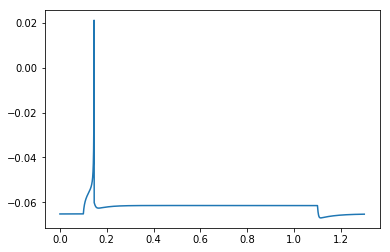

In [12]:
import os
import pickle
import matplotlib.pyplot as plt
electro_path = str(os.getcwd())+'all_tests.p'

assert os.path.isfile(electro_path) == True
with open(electro_path,'rb') as f:
    (obs_frame,test_frame) = pickle.load(f)


rt = RheobaseTestP(obs_frame['Dentate gyrus basket cell']['Rheobase'])

pred = rt.generate_prediction(model)
print(pred)
#for i in npcl['pf'][0:2]:
iparams = {}
iparams['injected_square_current'] = {}
iparams['injected_square_current']['amplitude'] = pred['value']
model = None
model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
#model.set_attrs(i.dtc.attrs)

#['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
DELAY = 100.0*pq.ms
DURATION = 1000.0*pq.ms
iparams['injected_square_current']['delay'] = DELAY
iparams['injected_square_current']['duration'] = int(DURATION)
model.inject_square_current(iparams)
n_spikes = len(model.get_spike_train())

if n_spikes:
    print(n_spikes)
    #print(i[0].scores['RheobaseTestP']*pq.pA)
    plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())#,label='ground truth')
    plt.legend()
print(obs_frame['Dentate gyrus basket cell']['Rheobase'])
    
    

In [13]:
print(model)
help(dt[0])
dt = dt[0]()
dt[0].generate_prediction(model)


vanilla
Enabling NEURON+Python help system.
Help on class AP12AmplitudeChangePercentTest in module neuronunit.tests.dm:

class AP12AmplitudeChangePercentTest(Druckmann2013Test)
 |  13. Percent change in AP amplitude, first to second spike (%)
 |  
 |  Difference in AP amplitude between first and second AP divided by the first AP
 |  amplitude.
 |  
 |  Method resolution order:
 |      AP12AmplitudeChangePercentTest
 |      Druckmann2013Test
 |      neuronunit.tests.base.VmTest
 |      sciunit.tests.Test
 |      sciunit.base.SciUnit
 |      sciunit.base.Versioned
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  generate_prediction(self, model)
 |      Generates a prediction from a model using the required capabilities.
 |      No default implementation.
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  description = 'Difference in AP amplitude between first and second AP ...
 |  
 |  name =

TypeError: __init__() missing 1 required positional argument: 'current_amplitude'

In [ ]:
'''
import pdb
for d in dt:
    pdb.set_trace()
    #dmtO = d(pred['value'])#obs_frame['Dentate gyrus basket cell']['Rheobase'])
print(dmt0)
'''